# Binary Classification Model for MiniBooNE Particle Identification Using AutoKeras
### David Lowe
### October 16, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The MiniBooNE Particle Identification dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset is taken from the MiniBooNE experiment and is used to distinguish electron neutrinos (signal) from muon neutrinos (background). The researchers set up the data file as follows. The first line is the number of signal events followed by the number of background events. The records with the signal events come first, followed by the background events. Each line, after the first line, has the 50 particle ID variables for one event.

ANALYSIS: In another TensorFlow modeling exercise, the baseline model (2 layers with 32 nodes each) achieved an accuracy score of 95.17% after 20 epochs using the training dataset. After tuning the hyperparameters, the best model (2 layers with 512 nodes each) processed the validation dataset with an accuracy score of 97.88%. Furthermore, the final model processed the previously unseen test dataset with an accuracy score of 94.40%.

After a series of modeling trials, the best AutoKeras model (2 layers with 256 and 32 nodes) processed the validation dataset with a maximum accuracy score of 94.64%. When we applied the AutoKeras model to the previously unseen test dataset, we obtained an accuracy score of 94.54%.

CONCLUSION: In this iteration, the best TensorFlow model generated by AutoKeras appeared to be suitable for modeling this dataset. We should consider experimenting with AutoKeras for further modeling.

Dataset Used: MiniBooNE Particle Identification Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification

Any predictive modeling machine learning project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL boto3

In [2]:
# pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc2
# pip install autokeras

In [3]:
# Clean up outstanding AutoKeras working folder and files
!rm -rf structured_data_classifier/

In [4]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [5]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [6]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [7]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [8]:
# Set the random seed number for reproducible results
seedNum = 888

In [9]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from autokeras import StructuredDataClassifier

### 1.b) Set up the controlling parameters and functions

In [10]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epochs = 20
default_batch = 32
default_trials = 50

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.0


In [11]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [12]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [13]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [14]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [15]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt'
signal_rec = 36499
widthVector = [14] * 50
colNames = ['particle' + str(i).zfill(2) for i in range(1,51)]
Xy_original = pd.read_fwf(dataset_path, widths=widthVector, header=None, names=colNames, skiprows=1, index_col=False, na_values=[-999])
Xy_original['targetVar'] = 0
Xy_original.iloc[:signal_rec, len(Xy_original.columns)-1] = 1

# Take a peek at the dataframe after import
Xy_original.head()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,particle11,particle12,particle13,particle14,particle15,particle16,particle17,particle18,particle19,particle20,particle21,particle22,particle23,particle24,particle25,particle26,particle27,particle28,particle29,particle30,particle31,particle32,particle33,particle34,particle35,particle36,particle37,particle38,particle39,particle40,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.8850,0.928671,0.140918,2.58663,1689.070,1.197950,19.3561,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.22299,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.7180,0.882784,0.368855,2.24638,1388.260,0.839230,6.6951,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.31717,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.3960,0.412250,0.434002,2.38485,992.098,0.514175,16.0030,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.18765,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.8656,0.833067,0.181294,2.49837,1289.160,0.630307,12.9374,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.70034,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.6680,0.398421,0.353034,2.04136,949.231,0.389585,13.9175,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.68793,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130064 entries, 0 to 130063
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   particle01  129596 non-null  float64
 1   particle02  129596 non-null  float64
 2   particle03  129596 non-null  float64
 3   particle04  129596 non-null  float64
 4   particle05  129596 non-null  float64
 5   particle06  129596 non-null  float64
 6   particle07  129596 non-null  float64
 7   particle08  129596 non-null  float64
 8   particle09  129596 non-null  float64
 9   particle10  129596 non-null  float64
 10  particle11  129596 non-null  float64
 11  particle12  129596 non-null  float64
 12  particle13  129596 non-null  float64
 13  particle14  129596 non-null  float64
 14  particle15  129596 non-null  float64
 15  particle16  129596 non-null  float64
 16  particle17  129596 non-null  float64
 17  particle18  129596 non-null  float64
 18  particle19  129596 non-null  float64
 19  pa

In [17]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,particle11,particle12,particle13,particle14,particle15,particle16,particle17,particle18,particle19,particle20,particle21,particle22,particle23,particle24,particle25,particle26,particle27,particle28,particle29,particle30,particle31,particle32,particle33,particle34,particle35,particle36,particle37,particle38,particle39,particle40,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,1.295960e+05,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,130064.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,4.320184,165.637813,0.451207,0.310498,2.249992,940.012246,0.455370,27.003274,0.268207,1.239488e+02,-0.100292,0.308583,84.551884,3.846727,0.440647,-0.601605,101.363382,1.566258,0.173660,-0.305566,7.574202,1.015175,1.216976,366.853345,0.073159,0.295732,0.390668,-2.780269,1.281083,0.091469,145.297502,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.280623
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,0.341045,114.924101,0.522894,0.242053,0.701960,643.578142,0.416951,30.134923,0.052030,4.444768e+04,1.878655,0.048147,85.183310,1.800936,0.057913,2.086586,72.976893,0.259066,0.055298,0.595808,2.309038,0.387757,0.757159,96.599850,0.042591,0.068787,0.854253,0.997677,0.288151,0.040801,31.766619,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449306
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,0.000000,-6.964110,-0.999999,0.000000,0.959427,135.279000,0.002533,0.627859,0.057435,-1.725670e+04,-23.588100,0.048611,0.000000,1.164330,0.000000,-39.630200,0.000000,0.756133,0.000000,-3.351610,2.393770,-1.554760,0.002855,6.336270,0.000000,0.042931,-1.656240,-13.166500,0.144033,0.000000,33.895200,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,4.153370,74.464900,0.157235,0.112941,1.781320,564.558000,0.214943,9.970900,0.233788,4.709923e-01,-0.841143,0.277166,36.163950,2.695650,0.414901,-0.919210,33.929325,1.393690,0.136414,-0.681480,5.908910,0.752261,0.648651,306.211500,0.040368,0.248382,-0.197939,-3.476897,1.093590,0.065230,123.193000,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,4.290050,156.393000,0.635537,0.245068,2.098055,733.919500,0.315752,18.353000,0.260359,7.870820e-01,0.221760,0.307229,58.082800,3.509755,0.459645,0.004704,109.412000,1.560525,0.164287,-0.249980,7.216690,1.033540,1.046210,386.332000,0.067315,0.292126,0.205421,-2.730490,1.270890,0.083774,145.538500,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,4.435650,244.917250,0.874057,0.469693,2.526682,1050.710000,0.508807,33.221050,0.293729,1.078005e+00,0.949670,0.337880,98.242225,4.570645,0.483323,0.400877,145.221000,1.716770,0.202968,0.092412

In [18]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

particle01    468
particle02    468
particle03    468
particle04    468
particle05    468
particle06    468
particle07    468
particle08    468
particle09    468
particle10    468
particle11    468
particle12    468
particle13    468
particle14    468
particle15    468
particle16    468
particle17    468
particle18    468
particle19    468
particle20    468
particle21    468
particle22    468
particle23    468
particle24    468
particle25    468
particle26    468
particle27    468
particle28    468
particle29    468
particle30    468
particle31    468
particle32    468
particle33    468
particle34    468
particle35    468
particle36    468
particle37    468
particle38    468
particle39    468
particle40    468
particle41    468
particle42    468
particle43    468
particle44    468
particle45    468
particle46    468
particle47    468
particle48    468
particle49    468
particle50    468
dtype: int64
Total number of NaN in the dataframe: 23400


### 1.d) Data Cleaning

In [19]:
# Dropping rows with NA's
Xy_original.dropna(axis=0, inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,particle11,particle12,particle13,particle14,particle15,particle16,particle17,particle18,particle19,particle20,particle21,particle22,particle23,particle24,particle25,particle26,particle27,particle28,particle29,particle30,particle31,particle32,particle33,particle34,particle35,particle36,particle37,particle38,particle39,particle40,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.8850,0.928671,0.140918,2.58663,1689.070,1.197950,19.3561,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.22299,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.7180,0.882784,0.368855,2.24638,1388.260,0.839230,6.6951,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.31717,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.3960,0.412250,0.434002,2.38485,992.098,0.514175,16.0030,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.18765,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.8656,0.833067,0.181294,2.49837,1289.160,0.630307,12.9374,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.70034,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.6680,0.398421,0.353034,2.04136,949.231,0.389585,13.9175,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.68793,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1


In [20]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129596 entries, 0 to 130063
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   particle01  129596 non-null  float64
 1   particle02  129596 non-null  float64
 2   particle03  129596 non-null  float64
 3   particle04  129596 non-null  float64
 4   particle05  129596 non-null  float64
 5   particle06  129596 non-null  float64
 6   particle07  129596 non-null  float64
 7   particle08  129596 non-null  float64
 8   particle09  129596 non-null  float64
 9   particle10  129596 non-null  float64
 10  particle11  129596 non-null  float64
 11  particle12  129596 non-null  float64
 12  particle13  129596 non-null  float64
 13  particle14  129596 non-null  float64
 14  particle15  129596 non-null  float64
 15  particle16  129596 non-null  float64
 16  particle17  129596 non-null  float64
 17  particle18  129596 non-null  float64
 18  particle19  129596 non-null  float64
 19  pa

In [21]:
Xy_original.describe()

,particle01,particle02,particle03,particle04,particle05,particle06,particle07,particle08,particle09,particle10,particle11,particle12,particle13,particle14,particle15,particle16,particle17,particle18,particle19,particle20,particle21,particle22,particle23,particle24,particle25,particle26,particle27,particle28,particle29,particle30,particle31,particle32,particle33,particle34,particle35,particle36,particle37,particle38,particle39,particle40,particle41,particle42,particle43,particle44,particle45,particle46,particle47,particle48,particle49,particle50,targetVar
count,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,1.295960e+05,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000,129596.000000
mean,4.863931,1.492450,127.849703,0.283131,0.009311,0.160797,0.970221,0.823904,3.451369,0.173899,4.320184,165.637813,0.451207,0.310498,2.249992,940.012246,0.455370,27.003274,0.268207,1.239488e+02,-0.100292,0.308583,84.551884,3.846727,0.440647,-0.601605,101.363382,1.566258,0.173660,-0.305566,7.574202,1.015175,1.216976,366.853345,0.073159,0.295732,0.390668,-2.780269,1.281083,0.091469,145.297502,-21.709448,0.733346,6.009403,0.009058,0.178782,-0.159174,2.859957,1.613380,0.230708,0.281552
std,1.161277,0.860538,184.363509,0.059554,0.012493,0.122911,0.342953,0.070467,0.258654,0.043707,0.341045,114.924101,0.522894,0.242053,0.701960,643.578142,0.416951,30.134923,0.052030,4.444768e+04,1.878655,0.048147,85.183310,1.800936,0.057913,2.086586,72.976893,0.259066,0.055298,0.595808,2.309038,0.387757,0.757159,96.599850,0.042591,0.068787,0.854253,0.997677,0.288151,0.040801,31.766619,33.858218,1.224392,4.562213,0.029533,0.080407,0.977600,1.917000,1.960976,0.052818,0.449758
min,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,0.033432,0.000000,-6.964110,-0.999999,0.000000,0.959427,135.279000,0.002533,0.627859,0.057435,-1.725670e+04,-23.588100,0.048611,0.000000,1.164330,0.000000,-39.630200,0.000000,0.756133,0.000000,-3.351610,2.393770,-1.554760,0.002855,6.336270,0.000000,0.042931,-1.656240,-13.166500,0.144033,0.000000,33.895200,-387.617000,-1.686500,0.249186,0.000000,0.000000,-32.109800,-13.492200,-15.997800,0.000000,0.000000
25%,4.021948,0.882372,49.978850,0.241901,0.001245,0.086348,0.717548,0.783985,3.286500,0.143172,4.153370,74.464900,0.157235,0.112941,1.781320,564.558000,0.214943,9.970900,0.233788,4.709923e-01,-0.841143,0.277166,36.163950,2.695650,0.414901,-0.919210,33.929325,1.393690,0.136414,-0.681480,5.908910,0.752261,0.648651,306.211500,0.040368,0.248382,-0.197939,-3.476897,1.093590,0.065230,123.193000,-39.847675,-0.022607,3.428092,0.000000,0.122498,-0.336228,1.430775,0.281640,0.197748,0.000000
50%,4.793385,1.385640,106.423000,0.272313,0.005013,0.141468,0.924166,0.834244,3.427935,0.170756,4.290050,156.393000,0.635537,0.245068,2.098055,733.919500,0.315752,18.353000,0.260359,7.870820e-01,0.221760,0.307229,58.082800,3.509755,0.459645,0.004704,109.412000,1.560525,0.164287,-0.249980,7.216690,1.033540,1.046210,386.332000,0.067315,0.292126,0.205421,-2.730490,1.270890,0.083774,145.538500,-21.456250,0.462485,4.772420,0.000000,0.168887,0.043698,2.372290,1.130715,0.231553,0.000000
75%,5.632045,1.950260,138.994000,0.315312,0.013183,0.213450,1.181228,0.874354,3.586220,0.200121,4.435650,244.917250,0.874057,0.469693,2.526682,1050.710000,0.508807,33.221050,0.293729,1.078005e+00,0.949670,0.337880,98.242225,4.570645,0.483323,0.400877,145.221000,1.716770,0.202968,0.092412

In [22]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


### 1.e) Splitting Data into Sets

In [23]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [24]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (129596, 51) X_original.shape: (129596, 50) y_original.shape: (129596,)


In [25]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (103676, 50) y_train_df.shape: (103676,)
X_test_df.shape: (25920, 50) y_test_df.shape: (25920,)


In [26]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [27]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

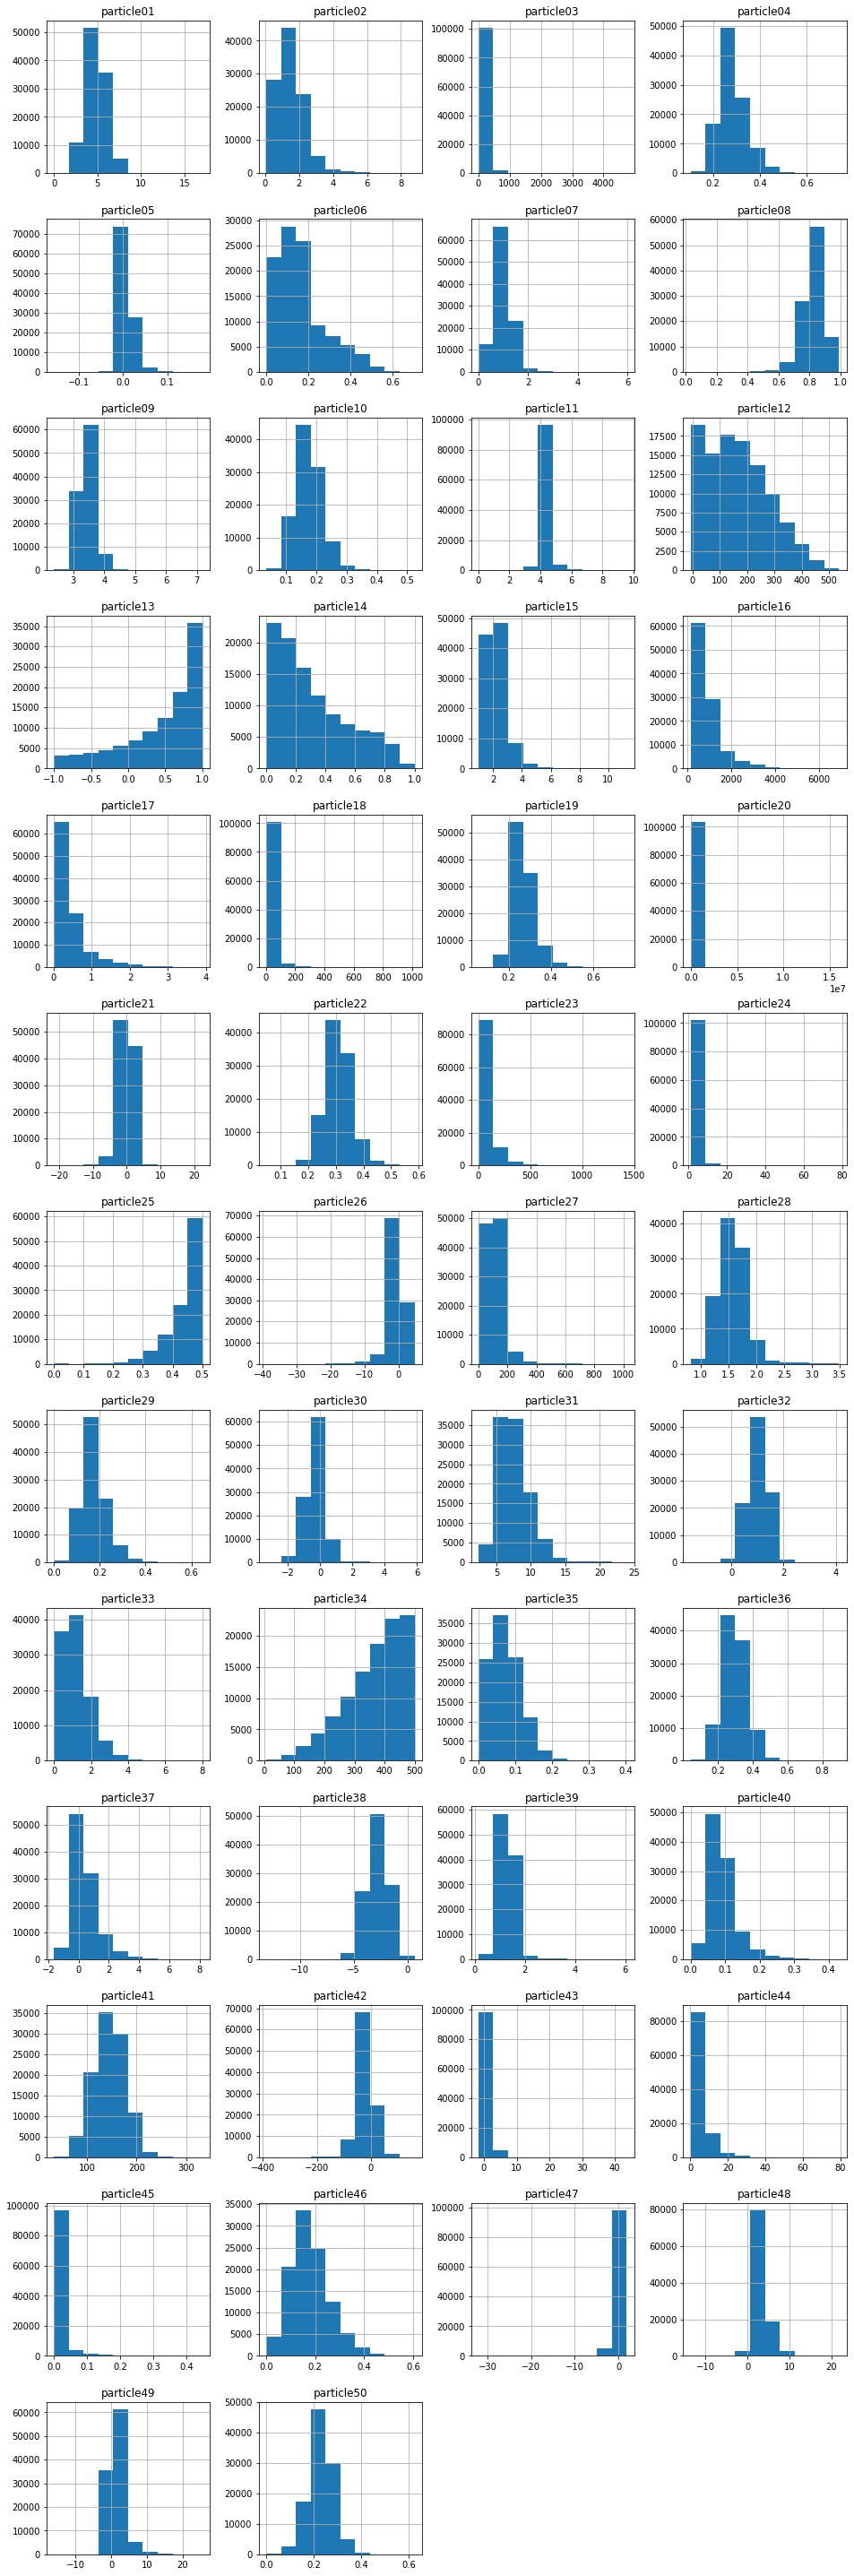

In [29]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

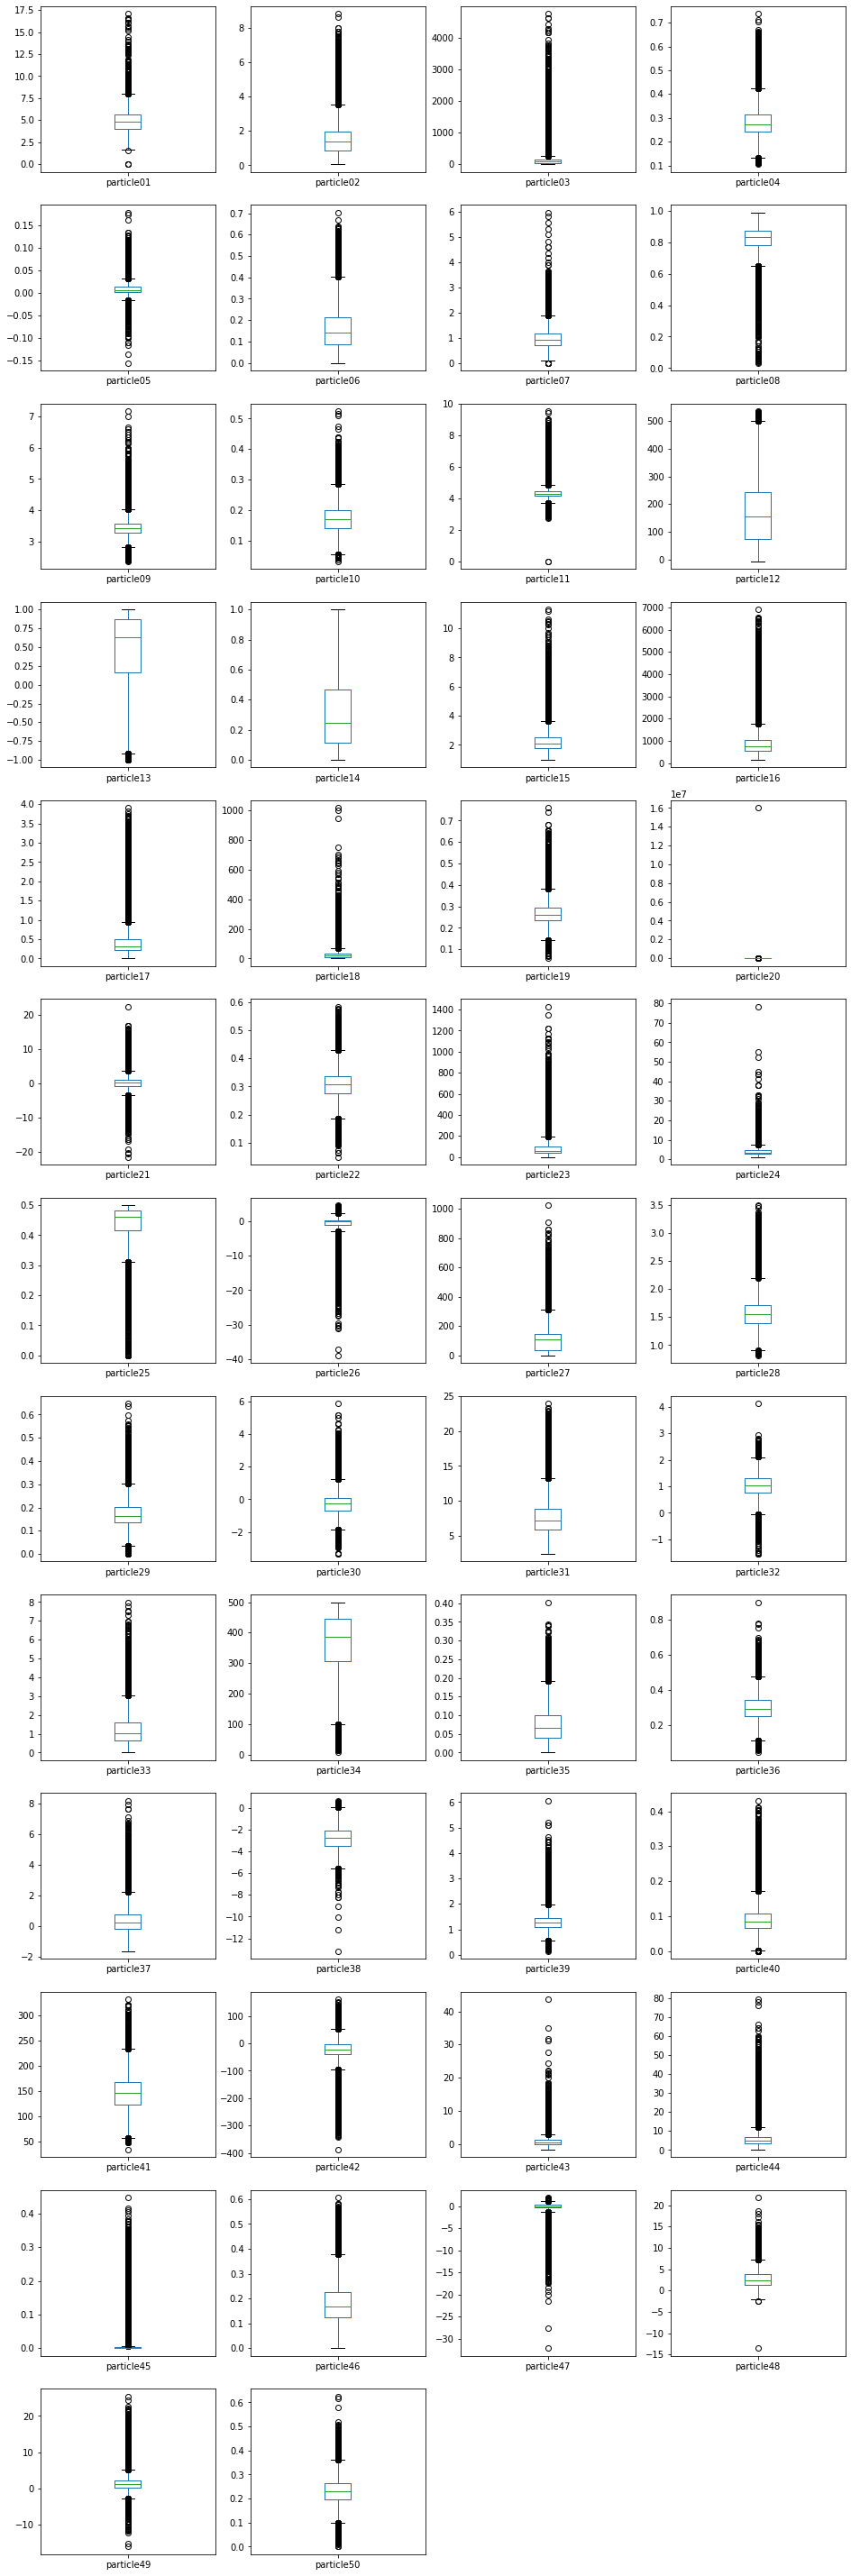

In [30]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

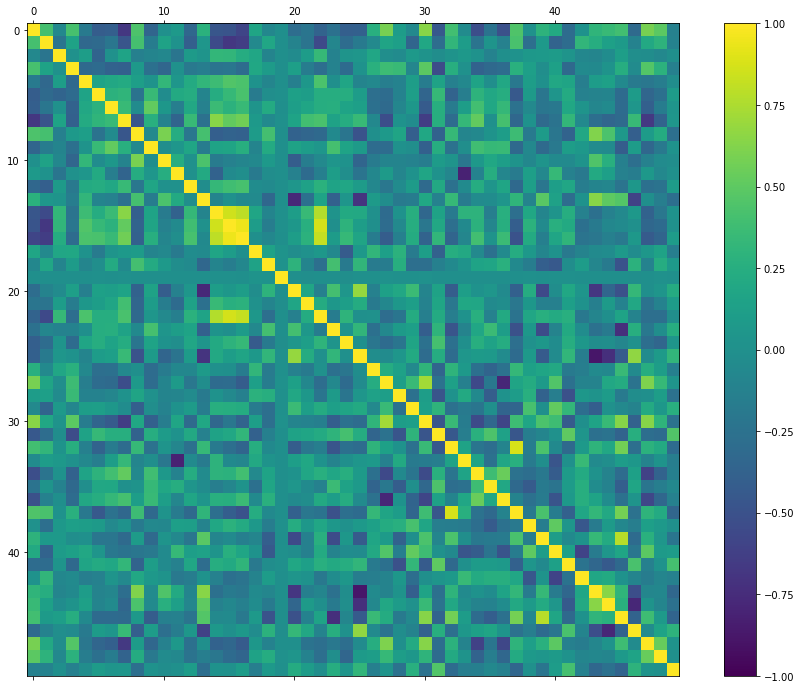

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [32]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [34]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 50
Number of categorical columns: 0
Total number of columns in the dataframe: 50


In [35]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

Transformed X_train.shape: (103676, 50)


### 3.b) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

### 3.c) Display the Final Datasets for Model-Building

In [37]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelEncoder()
y_train = class_encoder.fit_transform(y_train_df)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (103676, 50) y_train.shape: (103676,)


In [38]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [39]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
# Perform the model search
startTimeModule = datetime.now()
auto_model = StructuredDataClassifier(loss=default_loss, metrics=default_metrics, max_trials=default_trials, seed=seedNum)
auto_model.fit(x=X_train, y=y_train, epochs=default_epochs, validation_split=val_set_size, batch_size=default_batch, verbose=1)
final_model = auto_model.export_model()
print ('Model training time:', (datetime.now() - startTimeModule))

Trial 50 Complete [00h 04m 09s]
val_accuracy: 0.9456320405006409

Best val_accuracy So Far: 0.946480929851532
Total elapsed time: 03h 31m 21s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1860 - accuracy: 0.9292
Epoch 2/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1580 - accuracy: 0.9400
Epoch 3/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1506 - accuracy: 0.9424
Epoch 4/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1454 - accuracy: 0.9442
Epoch 5/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1422 - accuracy: 0.9455
Epoch 6/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1392 - accuracy: 0.9469
Epoch 7/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1369 - accuracy: 0.9478
Epoch 8/20
3240/3240 [==============================] - 13s 4ms/step - loss: 0.1350 - accuracy: 0.9

In [41]:
# Summarize the final model
final_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 50)                0         
_________________________________________________________________
normalization (Normalization (None, 50)                101       
_________________________________________________________________
dense (Dense)                (None, 256)               13056     
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

In [42]:
# Display the configuration details of the final model
final_model.to_json()

'{"class_name": "Functional", "config": {"name": "functional_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 50], "dtype": "string", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Custom>MultiCategoryEncoding", "config": {"name": "multi_category_encoding", "trainable": true, "dtype": "float32", "encoding": ["none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none"]}, "name": "multi_category_encoding", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Normalization", "config": {"name": "normalization", "trainable": true, "dtype": "float32", "ax

In [43]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [44]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [45]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = class_encoder.transform(y_test_df)
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (25920, 50) y_test.shape: (25920,)


In [46]:
test_predictions = auto_model.predict(X_test, batch_size=default_batch, verbose=1)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

810/810 [==============================] - 2s 3ms/step
Accuracy Score: 0.9454089506172839
[[17831   791]
 [  624  6674]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     18622
           1       0.89      0.91      0.90      7298

    accuracy                           0.95     25920
   macro avg       0.93      0.94      0.93     25920
weighted avg       0.95      0.95      0.95     25920



In [47]:
if notifyStatus: status_notify('(AutoKeras Binary Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 3:38:34.652272
